In [1]:
DATAPATH = '../data/'
XFERPATH = '~/gdrive/twitgen/'  # To transfer files from Google Colab
TRAIN_FNAME = 'embed_train_201906161241.csv'
VALID_FNAME = 'embed_valid_201906161241.csv'
TEST_FNAME = 'embed_test_201906161241.csv'
MODEL_TYPE_ID = 'lrp'

do_copy_files = False

In [2]:
if do_copy_files:
    train_from = XFERPATH + TRAIN_FNAME
    valid_from = XFERPATH + VALID_FNAME
    test_from = XFERPATH + TEST_FNAME
    !cp $train_from $DATAPATH
    !cp $valid_from $DATAPATH
    !cp $test_from $DATAPATH

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
timestamp = datetime.now().strftime('%Y%m%d%H%M')
timestamp

'201907301512'

In [5]:
df_train = pd.read_csv(DATAPATH+TRAIN_FNAME, index_col=[0,1], parse_dates=['time'])
df_valid = pd.read_csv(DATAPATH+VALID_FNAME, index_col=[0,1], parse_dates=['time'])
df_test = pd.read_csv(DATAPATH+TEST_FNAME, index_col=[0,1], parse_dates=['time'])
df_train.head().iloc[:,:7]

,,male,embed0,embed1,embed2,embed3,embed4,embed5
id,time,,,,,,,
1083596943807393792,2019-05-27 23:27:08+00:00,True,-9031,78190,28476,15732,-3761,22135
815783987784187904,2019-05-24 15:36:01+00:00,False,-1787,-57509,29939,-32859,-20955,13103
3458239641,2019-05-24 19:00:37+00:00,False,-42708,-31384,17130,60833,11307,35467
1003729876250226688,2019-05-26 12:53:00+00:00,True,-5514,61646,16234,105381,-7119,-35271
2360143940,2019-05-28 03:50:46+00:00,False,6762,-16422,-36991,29061,37017,-27550


In [6]:
# Remove duplicate index values
def remove_dups(df):
    return(df[~df.index.duplicated()])

In [7]:
df_train = remove_dups(df_train)
df_valid = remove_dups(df_valid)
df_test = remove_dups(df_test)

In [8]:
print(df_train.shape, df_valid.shape, df_test.shape)
print(df_train.index.get_level_values(1).min(), df_train.index.get_level_values(1).max())
print(df_valid.index.get_level_values(1).min(), df_valid.index.get_level_values(1).max())
print(df_test.index.get_level_values(1).min(), df_test.index.get_level_values(1).max())

(34115, 513) (10908, 513) (10441, 513)
2019-05-21 17:50:48+00:00 2019-05-28 12:44:26+00:00
2019-05-28 12:44:27+00:00 2019-05-30 12:09:54+00:00
2019-05-30 12:10:02+00:00 2019-06-01 19:55:43+00:00


In [9]:
def getxy(df):
    X = df.drop(['male'],axis=1).values / 1e6
    y = 1*df.male.values
    return(X, y)
    
X_train, y_train = getxy(df_train)
X_valid, y_valid = getxy(df_valid)
X_test, y_test = getxy(df_test)

In [10]:
pca = PCA(64)
pca.fit(X_train)
print(pca.explained_variance_ratio_)

[0.07448967 0.04572925 0.03132645 0.02649824 0.0248674  0.0233618
 0.02126058 0.0197315  0.01904902 0.01741447 0.01669775 0.01557568
 0.01513131 0.01465003 0.01418738 0.01328742 0.01317063 0.01251156
 0.01213346 0.01158146 0.01139212 0.01086771 0.01080612 0.0105357
 0.01015072 0.00983575 0.00959267 0.00949288 0.008994   0.00876515
 0.00861547 0.00836719 0.00814913 0.00809956 0.00798575 0.00770076
 0.00758359 0.00753871 0.00736204 0.00725604 0.00717286 0.00707758
 0.0068559  0.00680851 0.00646212 0.00634239 0.0062415  0.00622617
 0.00613874 0.00605179 0.00588575 0.00578923 0.00574028 0.00563339
 0.005556   0.00546179 0.0053614  0.00529546 0.00520805 0.0051176
 0.00500532 0.00494842 0.00481295 0.00477483]


In [11]:
model = Pipeline([('pca',  PCA(50)),
                  ('poly', PolynomialFeatures()),
                  ('lr',   LogisticRegression(C=.08))])
model = model.fit(X_train, y_train)

/home/andy/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
def save_predictions(df, predictions, which_set):
    pred_df = df[['male']].copy()
    pred_df['pred'] = predictions
    path = DATAPATH + MODEL_TYPE_ID + '_' + which_set + '_pred_' + timestamp + '.csv'
    pred_df.to_csv(path)    

In [13]:
y_train_pred = model.predict_proba(X_train)[:,1]
save_predictions(df_train, y_train_pred, 'train')
f1_score(y_train, y_train_pred>.5)

0.7043896149563382

In [14]:
y_pred = model.predict_proba(X_valid)[:,1]
save_predictions(df_valid, y_pred, 'valid')
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[3303 2153]
 [1911 3541]]


0.6353848914408756

In [15]:
accuracy_score(y_valid, y_pred>.5)

0.6274294096076274

In [16]:
y_test_pred = model.predict_proba(X_test)[:,1]
save_predictions(df_test, y_test_pred, 'test')
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[3133 2087]
 [1885 3336]]


0.6268320180383314

In [17]:
accuracy_score(y_test, y_test_pred>.5)

0.6195766689014462

Test set ROC AUC: 0.6748006136432518


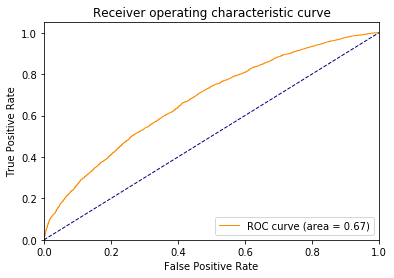

In [18]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
print('Test set ROC AUC: {}'.format(auc(fpr, tpr)))
plt.show()

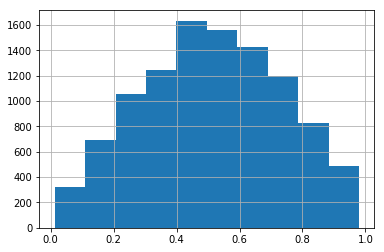

In [19]:
pd.Series(y_test_pred).hist()
plt.show()

In [20]:
df_acc = pd.DataFrame(columns=['minprob','maxprob','count','accuracy','lconf95','hconf95'])
for pbot in np.linspace(0,.9,10):
    ptop = pbot+.1
    mask = (y_test_pred>=pbot)&(y_test_pred<ptop)
    count = int(mask.sum())
    if count>0:
        actual = pd.Series(y_test)[mask].values
        pred_prob = pd.Series(y_test_pred)[mask].values
        pred_bin = pred_prob>.5
        acc = accuracy_score(actual, pred_bin)
        nsucc = sum(actual==pred_bin)
        confint = proportion_confint(nsucc, count)
        minconf = confint[0]
        maxconf = confint[1]
    else:
        acc = np.nan
        minconf = np.nan
        maxconf = np.nan
    row = pd.DataFrame({'minprob':[pbot], 'maxprob':[ptop], 'count':[count], 
                        'accuracy':[acc], 'lconf95':[minconf], 'hconf95':[maxconf]})
    df_acc = pd.concat([df_acc, row], sort=False)
df_acc.set_index(['minprob','maxprob'])

,,count,accuracy,lconf95,hconf95
minprob,maxprob,,,,
0.0,0.1,269,0.840149,0.796355,0.883942
0.1,0.2,695,0.758273,0.726444,0.790103
0.2,0.3,1058,0.679584,0.651466,0.707702
0.3,0.4,1297,0.587510,0.560718,0.614301
0.4,0.5,1699,0.529135,0.505400,0.552869
0.5,0.6,1601,0.511555,0.487070,0.536041
0.6,0.7,1458,0.580247,0.554915,0.605579
0.7,0.8,1176,0.634354,0.606828,0.661880
0.8,0.9,823,0.737546,0.707487,0.767604


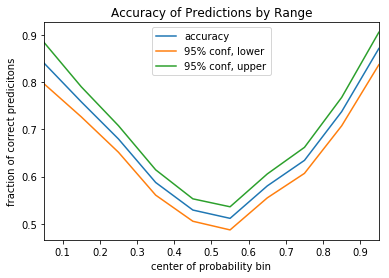

In [21]:
df_acc['avgprob'] = .5*(df_acc.minprob+df_acc.maxprob)
ax = df_acc.drop(['count','minprob','maxprob'],axis=1).set_index('avgprob').plot(
        title='Accuracy of Predictions by Range')
ax.legend(labels=['accuracy', '95% conf, lower', '95% conf, upper'])
ax.set(xlabel="center of probability bin", ylabel="fraction of correct predicitons")
plt.show()

In [22]:
from joblib import dump
model_path = DATAPATH + MODEL_TYPE_ID + '_model_' + timestamp + '.joblib'
dump(model, model_path)

['../data/lrp_model_201907301512.joblib']